# 과제 - 5주차

## 다운로드, 정제, 저장을 하나의 task로 작성할지, 별도의 task 를 두고 dependency 를 설정할지 결정해보세요

* 아래의 Task로 구분해서 진행
  * 다운로드
  * 오래된 파일 삭제
  * 정제 및 저장
* Dependency는 원본 파일의 다운/삭제가 완료된 후에 정제/저장이 되도록 설정

## 데이터 다운로드, 정제, 저장 기능을 수행하는 DAG 를 작성하고 스케줄링을 적용해보세요

### 진행방안
* 작업 중 오류 발생시 Slack으로 로그 전송
  * 작업명, 실행시간, 로그 등 전송

* 기준일자 계산
  * Airflow의 작업일자를 기준으로 파일을 다운로드/삭제할 기준일자 계산
  * Airflow작업실패시 `catchup=True`로 기준일자 자동계산하여 변수 수정 등 없이 자동진행
  
* 파일에 대한 작업을 먼저 진행한 뒤 Slack으로 결과 전송
  * 다운로드와 삭제는 어느 것이 먼저 진행되어도 무방
  * 다운로드와 삭제함수가 내역을 리턴하고, Slack이 해당 내용(파일내역)으로 작업완료 알림
  
* Spark로 데이터를 정제한 뒤 저장하고, Slack으로 결과 전송
  * 데이터를 정제한 뒤 저장하고, Text파일로 Dataframe결과표를 저장
    * airflow variable에 저장하는 것으로 변경
  * Text파일의 표를 Slack으로 전송하여 작업결과를 공유
    * airflow variable에서 가져오는 것으로 변경
  
### Airflow Graph

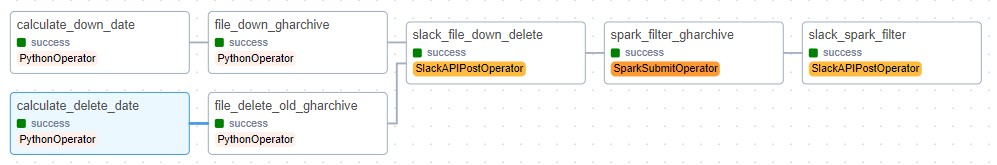

### Slack 결과 샘플

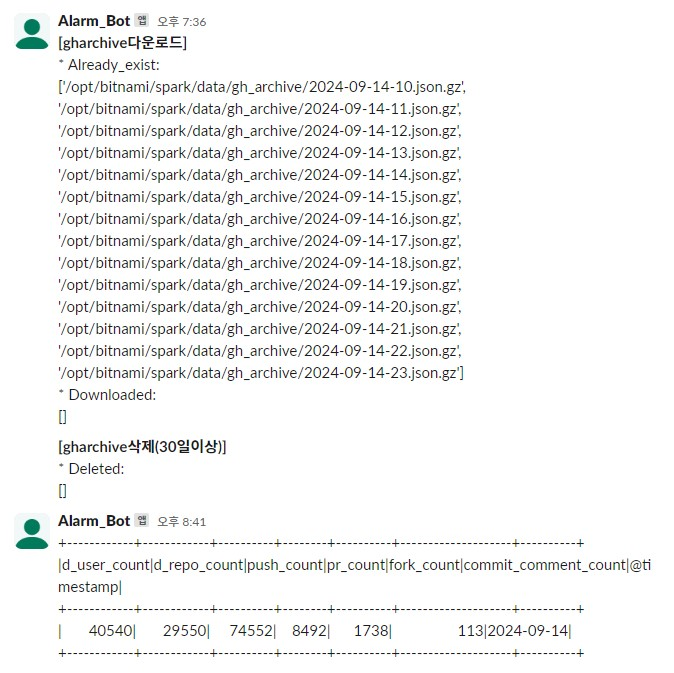

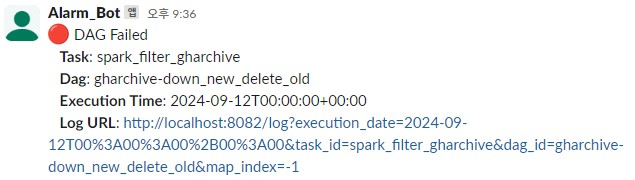

### 코드

In [ ]:
from airflow import DAG
from airflow.operators.python import PythonOperator
from airflow.providers.apache.spark.operators.spark_submit import SparkSubmitOperator
from airflow.providers.slack.operators.slack import SlackAPIPostOperator
from airflow.models.baseoperator import chain
from airflow.models import Variable
from datetime import datetime, timedelta

import sys
sys.path.append('/opt/airflow/jobs')
from airflowjob_down_new_delete_old import down_from_gharchive, del_old_file_gharchive

# 오류시 메시지를 보낼 함수 정의
def slack_failure_callback(context):
    slack_msg = f"""
    :red_circle: DAG Failed
    *Task*: {context.get('task_instance').task_id}
    *Dag*: {context.get('task_instance').dag_id}
    *Execution Time*: {context.get('execution_date')}
    *Log URL*: {str(context.get('task_instance').log_url).replace(':8080',':8082')}
    """
    
    slack_alert = SlackAPIPostOperator(
            slack_conn_id="slack_pkb",
            task_id='send_error_with_slack',
            channel='#alarm',  # 전송할 Slack 채널
            dag=dag,
            blocks=[
                {
                    "type": "section",
                    "text": {
                        "type": "mrkdwn",
                        "text": (
                            slack_msg
                        ),
                    },
                }
            ],
            text="Airflow Error",  # 필수 fallback 메시지
        )
    return slack_alert.execute(context=context)

# DAG
dag = DAG("gharchive-down_new_delete_old", 
          default_args={
            "owner": "airflow",
            "depends_on_past": False, # 과거 실행에 의존
            "start_date": datetime(2024, 9, 11),
            "retries": 1,             # retry 횟수
            "retry_delay": timedelta(minutes=3), # retry주기
            'on_failure_callback': slack_failure_callback,
            },
          catchup=True, 
          tags=['PKB','gharchive','down&delete'])

# Task0 : target_date 설정 (catchup 등으로 실행하는 부분 고려)
def set_down_date(**kwargs):
    print(f"Logical_date : {kwargs['logical_date']}")
    target_date_down = (kwargs['logical_date']- timedelta(days=1)).strftime('%Y-%m-%d')
    print(f'Calculated target_date_down : {target_date_down}')
    return target_date_down

down_date_calculate = PythonOperator(
    task_id='calculate_down_date',
    python_callable=set_down_date,
    provide_context=True,
    dag=dag,
)
## 기존 target_date_down 산출로직 (참고용)
# target_date_down = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')

def set_delete_date(**kwargs):
    print(f"Logical_date : {kwargs['logical_date']}")
    target_date_delete = (kwargs['logical_date']- timedelta(days=30)).strftime('%Y-%m-%d')
    print(f'Calculated target_date_delete : {target_date_delete}')
    return target_date_delete

delete_date_calculate = PythonOperator(
    task_id='calculate_delete_date',
    python_callable=set_delete_date,
    provide_context=True,
    dag=dag,
)
## 기존 target_date_delete 산출로직 (참고용)
# target_date_delete = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')


# Task1 : 다운로드
target_path = '/opt/bitnami/spark/data/gh_archive/'

download_from_gharchive = PythonOperator(
    task_id="file_down_gharchive",
    op_kwargs={"target_date_down": "{{task_instance.xcom_pull(task_ids='calculate_down_date')}}","target_path":target_path},
    python_callable = down_from_gharchive,
    dag=dag
)


# Task2 : 1달지난 파일 삭제

delete_old_of_filepath = PythonOperator(
    task_id="file_delete_old_gharchive",
    op_kwargs={"target_date_delete": "{{task_instance.xcom_pull(task_ids='calculate_delete_date')}}","target_path":target_path},
    python_callable = del_old_file_gharchive,
    dag=dag
)

# Task3 : 결과 전송 with Slack (위 Task에서 리턴받은 결과를 출력)
send_result_with_slack__file = SlackAPIPostOperator(
    slack_conn_id="slack_pkb",
    task_id='slack_file_down_delete',
    channel='#alarm',  # 전송할 Slack 채널
    dag=dag,
    blocks=[
        {
            "type": "section",
            "text": {
                "type": "mrkdwn",
                "text": (
                    "*[gharchive다운로드]*\n{{ task_instance.xcom_pull(task_ids='file_down_gharchive') }}\n\n"
                    "*[gharchive삭제(30일이상)]*\n{{ task_instance.xcom_pull(task_ids='file_delete_old_gharchive') }}"
                ),
            },
        }
    ],
    text="gharchive_file_downloaded_and_deleted",  # 필수 fallback 메시지
)


# Task4 : Spark 데이터 정제
spark_filter_gh = SparkSubmitOperator(
        task_id='spark_filter_gharchive',
        application="jobs/main_modified.py", # 절대경로라면 /opt/airflow/jobs/main.py
        application_args=["--target_date", "{{ task_instance.xcom_pull(task_ids='calculate_down_date') }}"],
        name="spark_filter_gh",
        conf={
            'spark.master': 'spark://spark-master:7077',  # master 설정
            'spark.dynamicAllocation.enabled': 'true',
            'spark.dynamicAllocation.executorIdleTimeout': '2m',
            'spark.dynamicAllocation.minExecutors': '1',
            'spark.dynamicAllocation.maxExecutors': '3',
            'spark.dynamicAllocation.initialExecutors': '1',
            'spark.memory.offHeap.enabled': 'true',
            'spark.memory.offHeap.size': '2G',
            'spark.shuffle.service.enabled': 'true',
            'spark.executor.memory': '2G',
            'spark.driver.memory': '2G',
            'spark.driver.maxResultSize': '0',
        },
        conn_id="spark-conn", # 필수값. UI에서 conenctivity 설정해둔 기준
        jars="/opt/bitnami/spark/resources/elasticsearch-spark-30_2.12-8.4.3.jar",
        executor_cores=1,
        num_executors=2,
        verbose=1,
        dag=dag
    )


# Task5 : 결과 전송 with Slack
def read_spark_output(**kwargs):
    with open("jobs/output.txt", "r") as f:
        output = f.read()
    return output  # Store the output in XCom

# send_result_with_slack__spark = SlackAPIPostOperator(
#     slack_conn_id="slack_pkb",
#     task_id='slack_spark_filter',
#     channel='#alarm',  # 전송할 Slack 채널
#     dag=dag,
#     blocks=[
#         {
#             "type": "section",
#             "text": {
#                 "type": "mrkdwn",
#                 "text": read_spark_output(),
#             },
#         }
#     ],
#     text="gharchive_spark_result",  # 필수 fallback 메시지
# )

send_result_with_slack__spark = SlackAPIPostOperator(
    slack_conn_id="slack_pkb",
    task_id='slack_spark_filter',
    channel='#alarm',  # 전송할 Slack 채널
    dag=dag,
    blocks=[
        {
            "type": "section",
            "text": {
                "type": "mrkdwn",
                "text": f'{Variable.get("gharchive_df")}',
            },
        }
    ],
    text="gharchive_spark_result",  # 필수 fallback 메시지
)


# Flow
chain([down_date_calculate, delete_date_calculate],
      [download_from_gharchive, delete_old_of_filepath],
      send_result_with_slack__file,
      spark_filter_gh,
      send_result_with_slack__spark)

#[down_date_calculate, delete_date_calculate] >> [download_from_gharchive, delete_old_of_filepath] >> send_result_with_slack__file >> spark_filter_gh >> send_result_with_slack__spark
